# TMDB Box Office Prediction
>
> This Notebook was created as part of Machine Learning in Finance lectured at Seoultech University.
>
> The dataset used for this project can be found [here](https://www.kaggle.com/c/tmdb-box-office-prediction) on the Kaggle Website.

---



In [1081]:
# Libraries
import ast
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score

# 1. Data Curation

## Load Data

In [1082]:
# Directory containing the csv files
dir_path = 'data'

# Load the data
train = pd.read_csv(f"{dir_path}/tmdb.csv")

> This dataset was used in a Kaggle competition from February 7th to May 31st in 2019.
> The target of the competition was to predict a movies revenue with only given information on the release date.
> The competition was hosted by Kaggle and a total of 1,615 people participated.

The target value `y` of my project will be `revenue`.
  - In the case of movies the most important feature has to be the amount of money the movie can gross after its release.
  - As most of the production companies have to generate profit in order to keep existing, movie-revenue has a high relevance.

All of the other columns will act as features `X` to predict `y`.

In [1083]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [1084]:
train.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,...,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,...,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt1600195,en,Lolita,Anna (Marceau) is a wife and mother who has an...,NaN,...,9/10/10,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Deadfall,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '5391990d0e0a260fb5001629', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,...,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,...,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,...,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,...,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,...,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,...,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


In [1085]:
# Check for missing values
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

## Blunt Observations

- There are **5 quantitative** and **18 qualitative** features in the dataset, one of them being the target value `revenue`.
- Out of the quantitative features the following are multi-value features:
  - `belongs_to_collection, geres, production_companies, production_countries, spoken_languages, Keywords, cast, crew`
- There are a lot of missing values for `belongs_to_collection` which likely means those are standalone movies without a collection and they can be later on corrected.
- `homepage` has also a lot of missing values which likely means the movie did not have a website for marketing. This can also be corrected later on.
- For the missing values in `overview, poster_path, production_companies, production_countries, runtime, spoken_languages, tagline, Keywords, cast, crew` we can assume that nobody was able to provide the missing values. The qualitative values are most likely not that relevant. The quantitative ones can be filled in with the median of the column.

## Fill-in Missing Data

For the numerical columns we can easily fill in missing values by finding the median of the columns.

In [1086]:
# Drop id column
train.drop('id', axis=1, inplace=True)

# Fill missing values in columns with either float or int data types with the median of those columns
num_cols = train.select_dtypes(include=[np.number])
train[num_cols.columns] = num_cols.apply(lambda x: x.fillna(x.median()))

# Verify that there are no missing values left in numeric columns
print(train[num_cols.columns].isna().sum())

budget        0
popularity    0
runtime       0
revenue       0
dtype: int64


For the moment the missing values in the qualitative columns will be left as is. In the feature engineering those values will get transformed in a meaningful way.

## Expectations

### Budget

- Among the quantitative features, I anticipate the highest correlation between `budget` and `revenue`.
  - From a production company's ex-ante perspective:
    - Allocating a substantial `budget` is often done with the expectation of achieving significant `revenue`.
  - From the model's ex-post perspective:
    - Observing high `revenue` may indicate that a significant `budget` was invested initially.

> Notably, studies have found a positive correlation between `budget` and gross `revenue`, with [one analysis](https://www.ijbmer.com/docs/volumes/vol9issue3/ijbmer2018090303.pdf) reporting a correlation coefficient of 0.74. This paper also states a positive correlation of 0.26 between `runtime` and gross `revenue`. I expect to see similar correlations in my dataset.

### Runtime

- Knowing the domain, a positive correlation exists between a movie's `budget` and its `runtime`. Higher budgets often allow for longer runtimes due to increased resources for production and editing. This implicitly provides information about the `revenue`.
  - From a production company's ex-ante perspective:
    - Allocating larger `budgets` with the expectation that a longer `runtime` will enhance storytelling and audience engagement, potentially leading to higher `revenues`.
  - From the model's ex-post perspective:
    - Observing a longer `runtime` often indicates that a significant `budget` was invested, as more extensive content typically requires greater financial resources.


### Popularity

- Pre-release `popularity` significantly influences a movie's box office `revenue`. 
  - Highly anticipated films often achieve greater financial success due to increased audience interest. This anticipation is frequently amplified by substantial marketing efforts, which are typically funded by larger `budgets`.
  

### Collection

- Belonging to a well-established movie franchise significantly influences a film's box office `revenue`. Several franchises exemplified this trend:
  - [**Harry Potter Series:**](https://en.wikipedia.org/wiki/Wizarding_World#Box_office_performance) The eight films released from 2001 to 2011 collectively grossed over $7.7 billion worldwide, averaging nearly $1 billion per film. 
  - [**The Lord of the Rings Trilogy:**](https://en.wikipedia.org/wiki/The_Lord_of_the_Rings_(film_series)#Box_office) Released between 2001 and 2003, this trilogy amassed approximately $2.9 billion globally, with each installment earning nearly $1 billion on average.
- Movies associated with established franchises often benefit from pre-existing fan bases, enhanced marketing leverage, and greater audience anticipation, all contributing to higher box office `revenues`.


### Production Company

- The `production company` behind a film significantly influences its box office revenue, particularly major studios that can allocate substantial budgets for production and marketing. 
- These studios often dominate market share and have the resources to produce high-quality films with extensive promotional campaigns, leading to higher `revenues`.


### Cast and Crew

- The caliber and amount of a movie's `cast` and `crew`, along with the allocated `budget`, plays a pivotal role in its box office success.
- Investing in renowned actors and skilled production teams often necessitates higher `budgets` but can lead to increased `revenues`.

### Other Features

In order to avoid falling into a rabbit hole, I will not look into all of the given features. Maybe there is a needle in the hay stack, but I believe the most relevant features are already mentioned above.

# 2. Exploratory Data Analysis

### Revenue (`y`-variable)

Let's take a look at the distribution of `revenue`.

In [1087]:
train['revenue'].describe().apply(lambda x: f'{x:,.0f}')

count            3,000
mean        66,725,852
std        137,532,326
min                  1
25%          2,379,808
50%         16,807,068
75%         68,919,204
max      1,519,557,910
Name: revenue, dtype: object

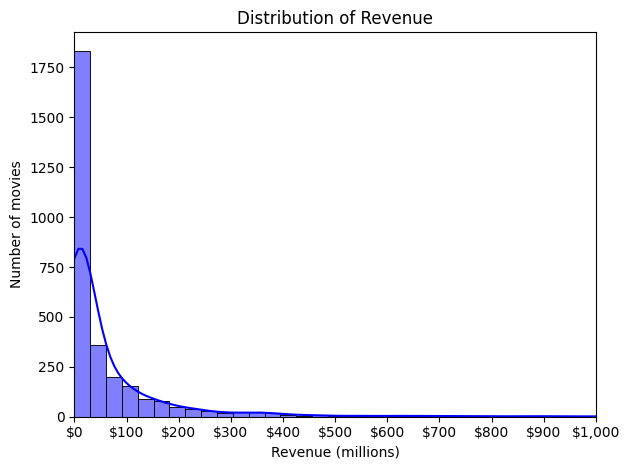

In [1088]:
sns.histplot(train['revenue'], bins=50, kde=True, color='blue')
plt.xlabel('Revenue (millions)')
plt.xticks([0, 100000000, 200000000, 300000000, 400000000, 500000000, 600000000, 700000000, 800000000, 900000000, 1000000000], ['$0', '$100', '$200', '$300', '$400', '$500', '$600', '$700', '$800', '$900', '$1,000'])
plt.xlim(0, 1000000000)
plt.ylabel('Number of movies')
plt.title('Distribution of Revenue')
plt.tight_layout()
plt.show()

The distribution of the revenue is heavily skewed to the right. Normalization of the datapoints with log can help increase the performance of the model.

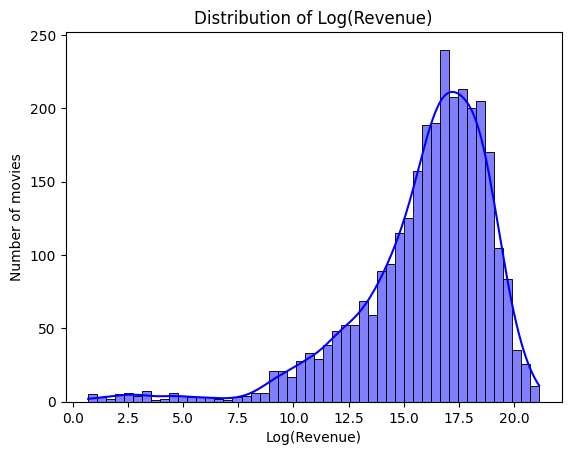

In [1089]:
log_revenue = np.log1p(train['revenue'])
sns.histplot(log_revenue, bins=50, kde=True, color='blue')
plt.xlabel('Log(Revenue)')
plt.ylabel('Number of movies')
plt.title('Distribution of Log(Revenue)')
plt.show()

Taking the logarithm of the revenue lead to a more normal distribution, stabilized variance, and provide coefficients that are easier to interpret in multiplicative terms. These advantages can improve the accuracy and interpretability of the revenue forecasting model.

### Budget, Runtime, Popularity

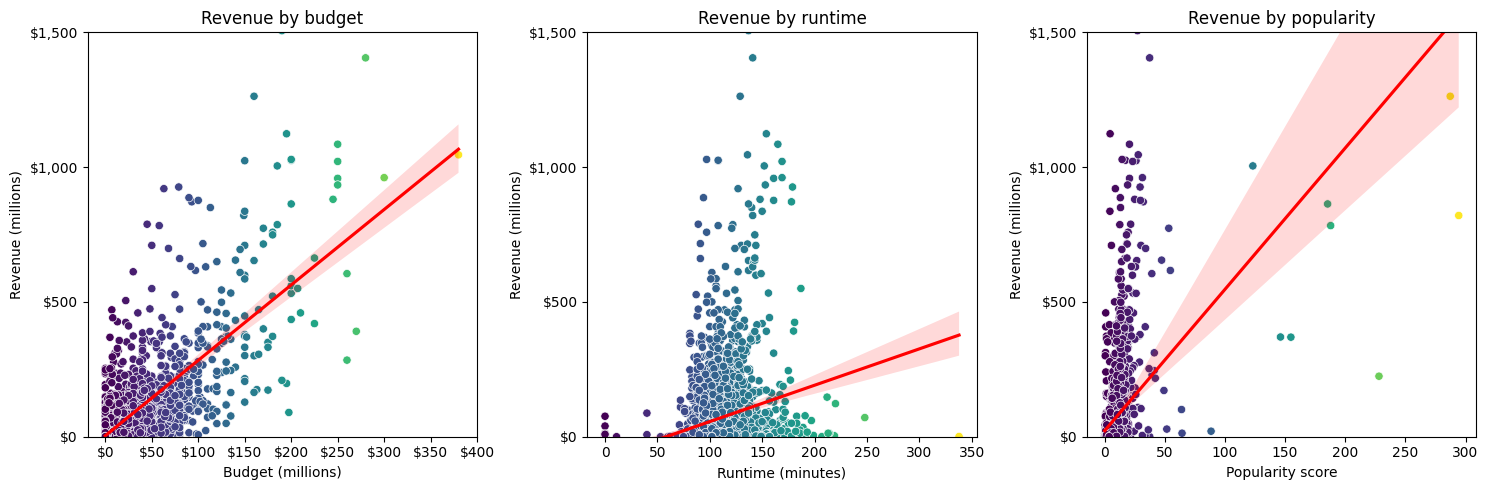

In [1090]:
# Budget
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=train.iloc[:3000], x='budget', y='revenue', hue='budget', palette='viridis')
sns.regplot(data=train.iloc[:3000], x='budget', y='revenue', scatter=False, color='red')
plt.xticks([0, 50000000, 100000000, 150000000, 200000000, 250000000, 300000000, 350000000, 400000000], ['$0', '$50', '$100', '$150', '$200', '$250', '$300', '$350', '$400'])
plt.ylim(0, 1500000000)
plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1,000', '$1,500'])
plt.title('Revenue by budget')
plt.xlabel('Budget (millions)')
plt.ylabel('Revenue (millions)')
plt.legend().remove()

# Runtime
plt.subplot(1, 3, 2)
sns.scatterplot(data=train.iloc[:3000], x='runtime', y='revenue', hue='runtime', palette='viridis')
sns.regplot(data=train.iloc[:3000], x='runtime', y='revenue', scatter=False, color='red')
plt.ylim(0, 1500000000)
plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1,000', '$1,500'])
plt.title('Revenue by runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Revenue (millions)')
plt.legend().remove()

# Popularity
plt.subplot(1, 3, 3)
sns.scatterplot(data=train.iloc[:3000], x='popularity', y='revenue', hue='popularity', palette='viridis')
sns.regplot(data=train.iloc[:3000], x='popularity', y='revenue', scatter=False, color='red')
plt.ylim(0, 1500000000)
plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1,000', '$1,500'])
plt.title('Revenue by popularity')
plt.xlabel('Popularity score')
plt.ylabel('Revenue (millions)')
plt.legend().remove()

plt.tight_layout()
plt.show()

There are some clear trends visible that an increase in budget and popularity tends to lead to higher revenue. Runtime seems to show this trend as well, although not as strongly. Let's compare the correlations.

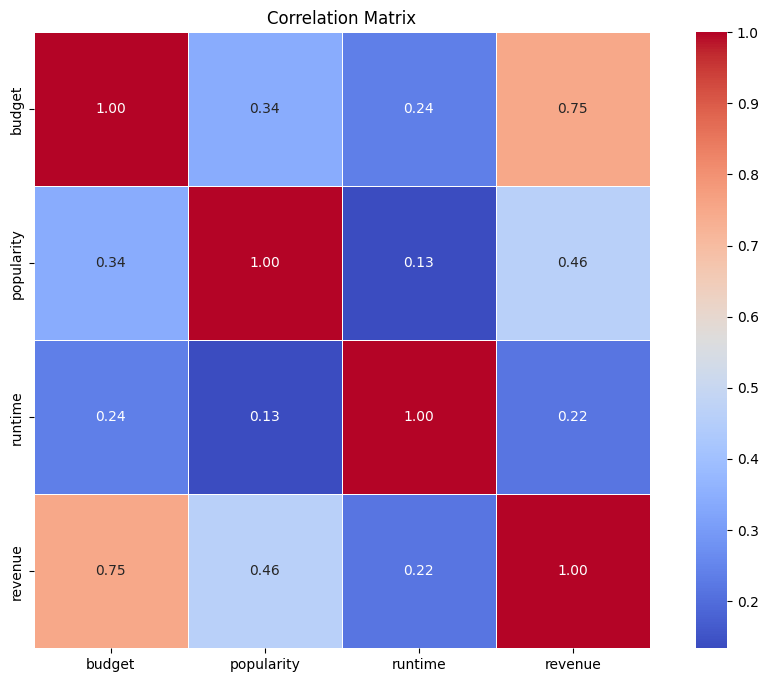

In [1091]:
# Select only numeric columns for correlation matrix
numeric_cols = train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Now it's very clear that `budget` and `popularity` have a high correlation with `revenue`, just as expected. The `runtime` seems to also have a fairly noticeable correlation.

### Feature Engineering

#### Collection

First I will transform the `belongs_to_collection` columns into two different ones. One binary one indicating whether a movie belongs to a collection and one containing only the main title of the collection.

In [1092]:
# Extract collection names
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: ast.literal_eval(x)[0]['name'] if pd.notna(x) and ast.literal_eval(x) else None)

# Change column to indicate whether a movie belongs to a collection or not
train['belongs_to_collection'] = train['belongs_to_collection'].apply(lambda x: 1 if pd.notna(x) else 0)
train[['collection_name', 'belongs_to_collection']].head()

,collection_name,belongs_to_collection
0,Hot Tub Time Machine Collection,1
1,The Princess Diaries Collection,1
2,None,0
3,None,0
4,None,0


Let's plot the results.

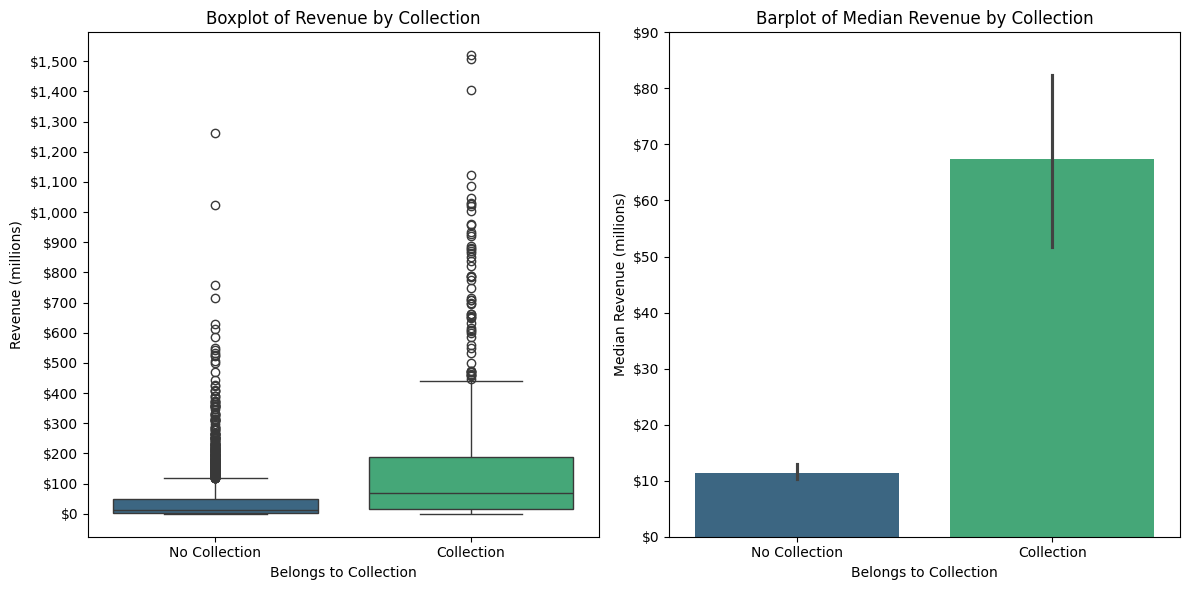

In [1093]:
# Create subplots
plt.figure(figsize=(12, 6))

# Boxplot for revenue by belongs_to_collection
plt.subplot(1, 2, 1)
sns.boxplot(data=train, x='belongs_to_collection', y='revenue', hue='belongs_to_collection', palette='viridis')
plt.xticks([0, 1], ['No Collection', 'Collection'])
plt.xlabel('Belongs to Collection')
plt.ylabel('Revenue (millions)')
plt.yticks(np.arange(0, 1600000000, 100000000), [f'${x//1000000:,}' for x in np.arange(0, 1600000000, 100000000)])
plt.title('Boxplot of Revenue by Collection')
plt.legend().remove()

# Barplot for median revenue by belongs_to_collection
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='belongs_to_collection', y='revenue', estimator=np.median, hue='belongs_to_collection', palette='viridis')
plt.xticks([0, 1], ['No Collection', 'Collection'])
plt.xlabel('Belongs to Collection')
plt.ylabel('Median Revenue (millions)')
plt.yticks(np.arange(0, 100000000, 10000000), [f'${x//1000000:,}' for x in np.arange(0, 100000000, 10000000)])
plt.title('Barplot of Median Revenue by Collection')
plt.legend().remove()

plt.tight_layout()
plt.show()

So we can see here that movies which belong to a collection seem to get higher revenues.

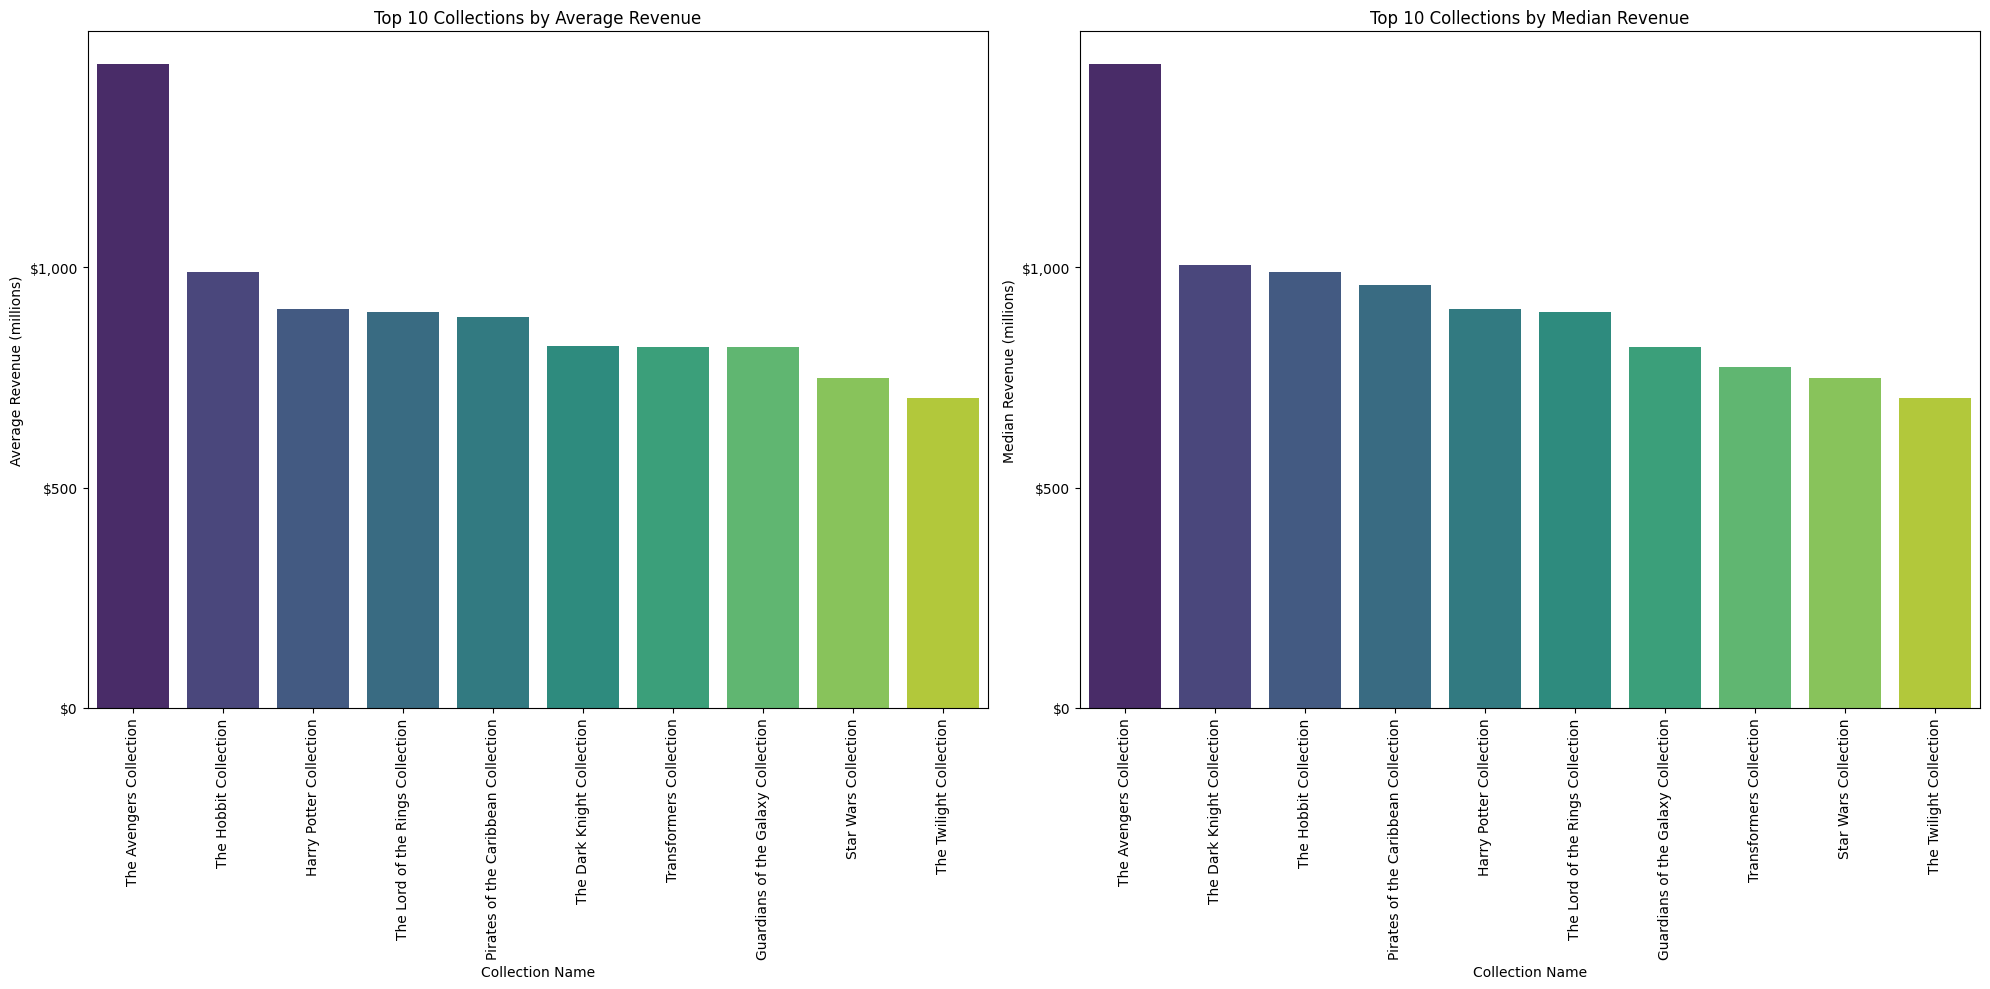

In [1094]:
# Group by collection name, count occurrences, and sort
collection_counts = train['collection_name'].value_counts().reset_index()
collection_counts.columns = ['collection_name', 'movie_count']

# Filter out collections with no name and display the head
collection_counts = collection_counts[collection_counts['collection_name'].notna()]
collection_counts.head(10)

# Define valid collections
valid_collections = collection_counts[collection_counts['movie_count'] > 1]['collection_name']

# Group by collection_name and calculate the median revenue for valid collections
collection_median_revenue = train[train['collection_name'].isin(valid_collections)].groupby('collection_name')['revenue'].median().reset_index()

# Sort the collections by median revenue in descending order and select the top 10
collection_median_revenue = collection_median_revenue.sort_values(by='revenue', ascending=False).head(10)

# Calculate the average revenue for valid collections
collection_revenue = train[train['collection_name'].isin(valid_collections)].groupby('collection_name')['revenue'].mean().reset_index()

# Sort the collections by average revenue in descending order and select the top 10
collection_revenue = collection_revenue.sort_values(by='revenue', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(20, 10))

# Average revenue plot
plt.subplot(1, 2, 1)
sns.barplot(data=collection_revenue, y='revenue', x='collection_name', hue='collection_name', palette='viridis')
plt.ylabel('Average Revenue (millions)')
plt.xlabel('Collection Name')
plt.title('Top 10 Collections by Average Revenue')
plt.yticks(np.arange(0, collection_revenue['revenue'].max(), step=500000000), [f'${int(x//1000000):,}' for x in np.arange(0, collection_revenue['revenue'].max(), step=500000000)])
plt.xticks(rotation=90)

# Median revenue plot
plt.subplot(1, 2, 2)
sns.barplot(data=collection_median_revenue, y='revenue', x='collection_name', hue='collection_name', palette='viridis')
plt.ylabel('Median Revenue (millions)')
plt.xlabel('Collection Name')
plt.title('Top 10 Collections by Median Revenue')
plt.yticks(np.arange(0, collection_median_revenue['revenue'].max(), step=500000000), [f'${int(x//1000000):,}' for x in np.arange(0, collection_median_revenue['revenue'].max(), step=500000000)])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Here we can see the collections with the highest revenues by average and median.

Let's take a look at the correlation of `belongs_to_collection` and the other numeric features.

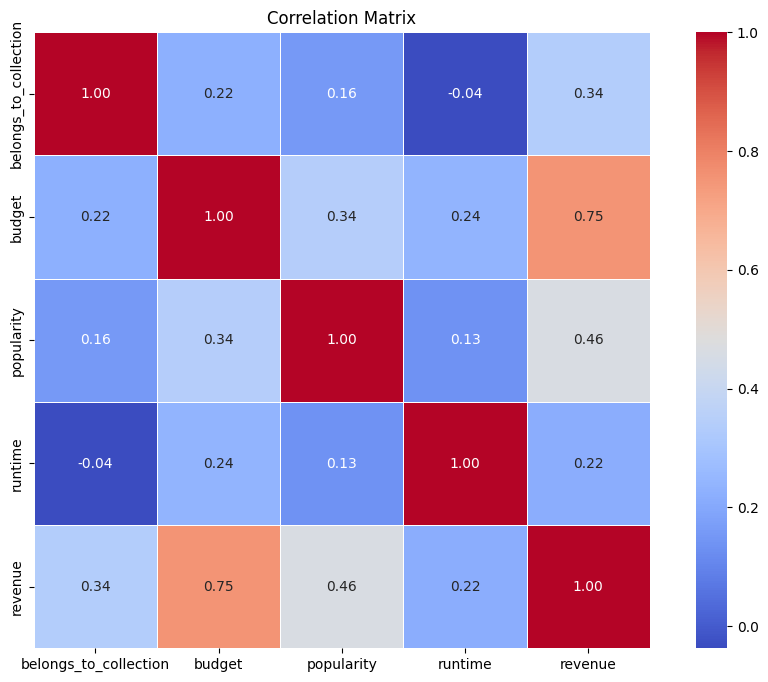

In [1095]:
# Select only numeric columns for correlation matrix
numeric_cols = train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

As expected we can observe a fairly high correlation between `belongs_to_collection` and `revenue`, even higher than `runtime`.

#### Production Company

For the production company I will use the first mentioned entry and assume that this is the main production company.

In [1096]:
# Function to extract the first production company name and id
def extract_main_production_company_info(companies):
    try:
        company = ast.literal_eval(companies)[0]
        return company['name']
    except (IndexError, ValueError, TypeError):
        return None

# Apply the function to the 'production_companies' column
train['main_prod_comp'] = train['production_companies'].apply(extract_main_production_company_info)

# Display the first few rows to verify
train[['production_companies', 'main_prod_comp']].head()

,production_companies,main_prod_comp
0,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",Paramount Pictures
1,"[{'name': 'Walt Disney Pictures', 'id': 2}]",Walt Disney Pictures
2,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...",Bold Films
3,NaN,None
4,NaN,None


In [1097]:
main_prod_comp_counts = train.groupby(['main_prod_comp']).size().reset_index(name='counts')
main_prod_comp_counts = main_prod_comp_counts.sort_values(by='counts', ascending=False)
main_prod_comp_counts.head(10)

,main_prod_comp,counts
977,Universal Pictures,167
706,Paramount Pictures,158
966,Twentieth Century Fox Film Corporation,122
210,Columbia Pictures,90
1006,Warner Bros.,70
649,New Line Cinema,69
1004,Walt Disney Pictures,62
961,TriStar Pictures,44
211,Columbia Pictures Corporation,44
974,United Artists,41


It seems like within the data there are some variations of the same company name. 

For example:
- Columbia Pictures, 90
- Columbia Pictures Corporation, 44

In order to avoid treating the same entity as different ones and create more accurate results, they can be grouped into a single one.

In [1098]:
# Dictionary of canonical company names
canonical_companies_mapping = {
    'Warner Bros.': 'Warner Bros',
    'Warner Bros. Pictures': 'Warner Bros',
    'Universal Pictures': 'Universal Pictures',
    'Universal Studios': 'Universal Pictures',
    'Twentieth Century Fox': 'Twentieth Century Fox',
    'Twentieth Century Fox Film Corporation':'Twentieth Century Fox',
    'Columbia Pictures': 'Columbia Pictures',
    'Columbia Pictures Corporation': 'Columbia Pictures',
    'Walt Disney Pictures': 'Walt Disney Pictures',
    'Walt Disney': 'Walt Disney Pictures',
    'Walt Disney Productions': 'Walt Disney Pictures',
    'Canal Plus': 'Canal Plus',
    'Canal+': 'Canal Plus',
    'StudioCanal': 'Canal Plus',
    'Studio Canal': 'Canal Plus',
    'Lionsgate': 'Lionsgate',
    'Lions Gate Films': 'Lionsgate',
    'LionsGate': 'Lionsgate',
    'Dreamworks Pictures': 'Dreamworks Pictures',
    'DreamWorks Pictures': 'Dreamworks Pictures',
    'DreamWorks SKG': 'Dreamworks Pictures',
    'DreamWorks Animation': 'Dreamworks Pictures',
    'Metro-Goldwyn-Mayer (MGM)': 'Metro Goldwyn Mayer',
}

# Correct the main_prod_comp column using the canonical_companies_mapping dictionary
train['main_prod_comp'] = train['main_prod_comp'].replace(canonical_companies_mapping)

# Count the occurrences of each main production company
main_prod_comp_counts = train['main_prod_comp'].value_counts().reset_index()
main_prod_comp_counts.columns = ['main_prod_comp', 'count']

# Display the list
main_prod_comp_counts.head(10)

,main_prod_comp,count
0,Universal Pictures,175
1,Paramount Pictures,158
2,Columbia Pictures,134
3,Twentieth Century Fox,123
4,Warner Bros,74
5,Walt Disney Pictures,69
6,New Line Cinema,69
7,TriStar Pictures,44
8,United Artists,41
9,Metro Goldwyn Mayer,40


In order to turn this feature into something manageable, I will use production companies with more than 40 movies. The rest is going to be treated as smaller companies and they will get the value `Other` assigned.

In [1099]:
# Create a dictionary to map production companies to their counts
prod_comp_counts_dict = main_prod_comp_counts.set_index('main_prod_comp')['count'].to_dict()

# Create the binary column 'major_prod_comp'
train['major_prod_comp'] = train['main_prod_comp'].apply(lambda x: 1 if prod_comp_counts_dict.get(x, 0) > 60 else 0)

# Display the first few rows to verify
train[['main_prod_comp', 'major_prod_comp']].head()

# Update main_prod_comp to 'Other' for samples with major_prod_comp equal to 0
train.loc[train['major_prod_comp'] == 0, 'main_prod_comp'] = 'Other'

# Display the first few rows to verify
train[['main_prod_comp', 'major_prod_comp']].head()

,main_prod_comp,major_prod_comp
0,Paramount Pictures,1
1,Walt Disney Pictures,1
2,Other,0
3,Other,0
4,Other,0


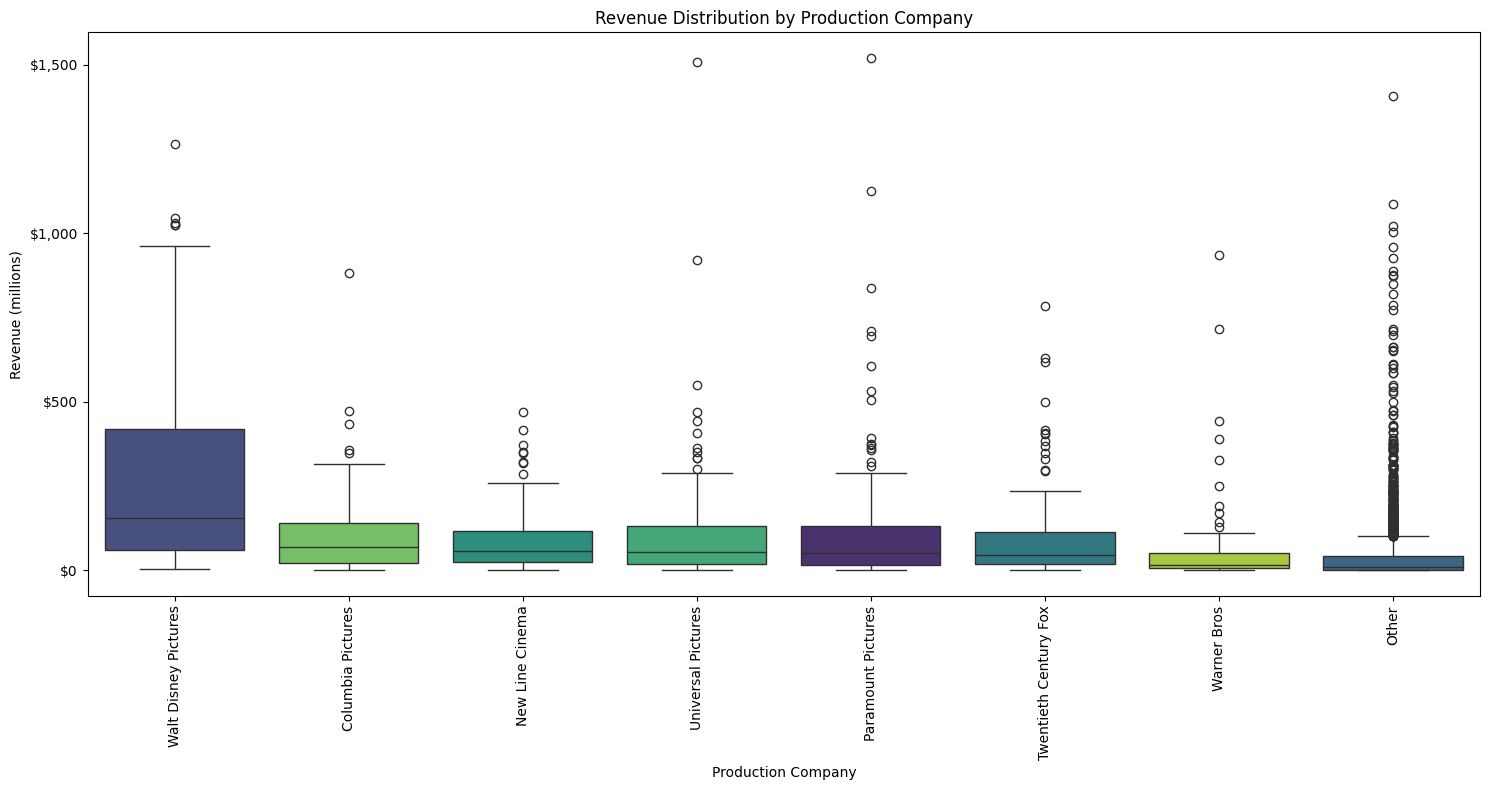

In [1100]:
# Calculate the median revenue for each production company
prod_comp_revenue = train.groupby('main_prod_comp')['revenue'].median().reset_index()

# Sort the production companies by median revenue in descending order
prod_comp_revenue = prod_comp_revenue.sort_values(by='revenue', ascending=False)

# Plot the data
plt.figure(figsize=(15, 8))
sns.boxplot(data=train, y='revenue', x='main_prod_comp', hue='main_prod_comp', order=prod_comp_revenue['main_prod_comp'], palette='viridis')
plt.ylabel('Revenue (millions)')
plt.xlabel('Production Company')
plt.title('Revenue Distribution by Production Company')
plt.yticks(np.arange(0, 1600000000, step=500000000), [f'${int(x//1000000):,}' for x in np.arange(0, 1600000000, step=500000000)])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- There is a highly noticeable gap between the first and the second ranked production company. **Walt Disney** seems to have a much higher impact on revenue than the other companies.
- For most of the *top* production companies the average revenue is higher than for the others.

In the next step I will use one-hot encoding in order to make this information useable for the training of the model. Afterwards we will look at the new correlations and find out whether we cooked or not.

In [1101]:
# Get the unique production companies
unique_prod_comps = train['main_prod_comp'].unique()

# Create binary columns for each production company
for comp in unique_prod_comps:
    column_name = f'prod_comp_{comp.replace(" ", "_").replace(".", "").replace("-", "_")}'
    train[column_name] = train['main_prod_comp'].apply(lambda x: 1 if x == comp else 0)

# Display the first few rows to verify
train.head()

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,main_prod_comp,major_prod_comp,prod_comp_Paramount_Pictures,prod_comp_Walt_Disney_Pictures,prod_comp_Other,prod_comp_Twentieth_Century_Fox,prod_comp_New_Line_Cinema,prod_comp_Universal_Pictures,prod_comp_Columbia_Pictures,prod_comp_Warner_Bros
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,...,Paramount Pictures,1,1,0,0,0,0,0,0,0
1,1,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,...,Walt Disney Pictures,1,0,1,0,0,0,0,0,0
2,0,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,Other,0,0,0,1,0,0,0,0,0
3,0,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,...,Other,0,0,0,1,0,0,0,0,0
4,0,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,...,Other,0,0,0,1,0,0,0,0,0


In [1102]:
train.drop(columns=['production_companies'], inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   belongs_to_collection            3000 non-null   int64  
 1   budget                           3000 non-null   int64  
 2   genres                           2993 non-null   object 
 3   homepage                         946 non-null    object 
 4   imdb_id                          3000 non-null   object 
 5   original_language                3000 non-null   object 
 6   original_title                   3000 non-null   object 
 7   overview                         2992 non-null   object 
 8   popularity                       3000 non-null   float64
 9   poster_path                      2999 non-null   object 
 10  production_countries             2945 non-null   object 
 11  release_date                     3000 non-null   object 
 12  runtime             

Now that the binary columns are added, let's see how they correlate with revenue.

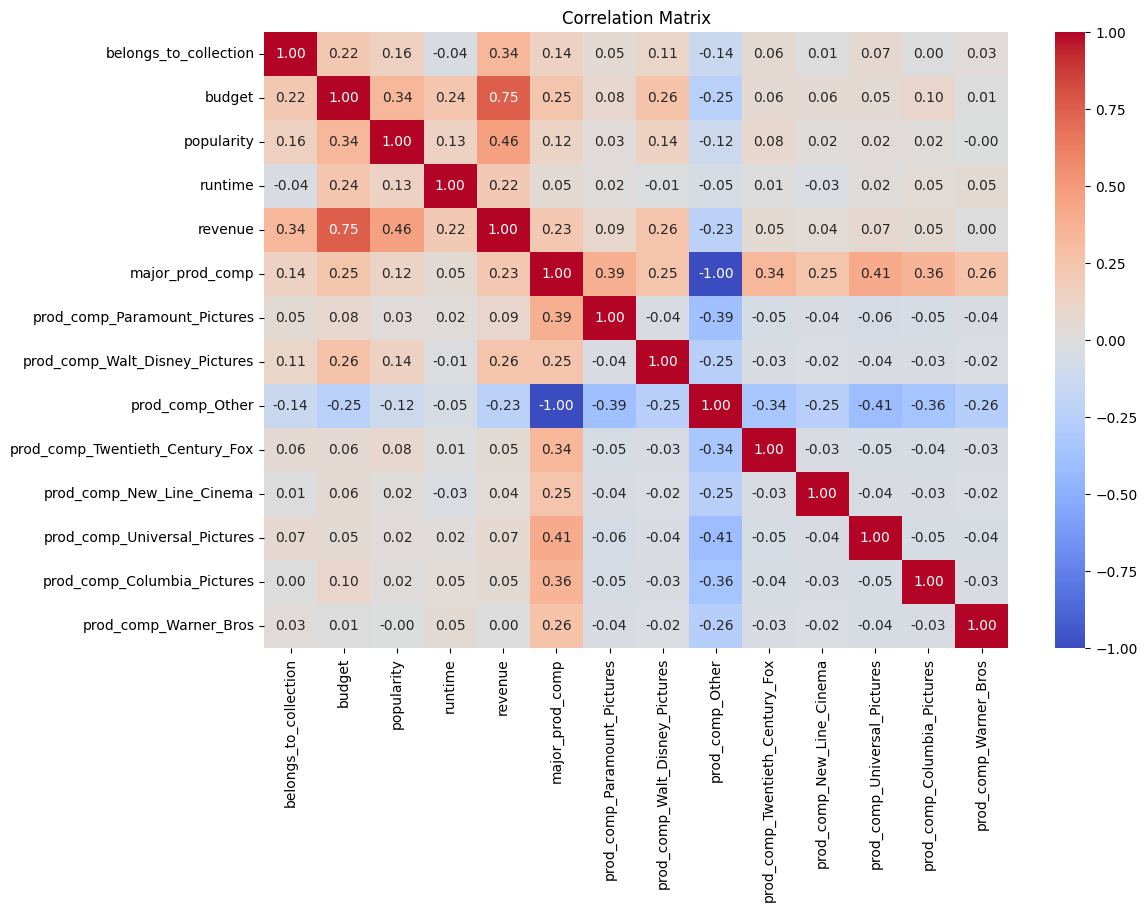

In [1103]:
# Select only numeric columns for correlation matrix
numeric_cols = train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

- From the newly engineered features we can see that really only **Walt Disney** has a high correlation. The other major companies seem to be even less relevant than the category `prod_comp_Other`.
- Also `major_prod_comp` has a noticeable correlation.

Let's retransform the less significant companies into **Other**, so that we end up with only the most significant ones.

In [1104]:
# List of production companies to keep as is
keep_companies = ['prod_comp_Walt_Disney_Pictures', 'prod_comp_Other']

# Get the list of all production company columns
prod_comps = [col for col in train.columns if col.startswith('prod_comp_')]

# Iterate over the columns and reassign values
for column in prod_comps:
    if column not in keep_companies:
        train['prod_comp_Other'] = train.apply(lambda row: 1 if row[column] == 1 else row['prod_comp_Other'], axis=1)

# Verify the changes
train[prod_comps].head()

# Drop all prod_comp columns that are not in keep_companies
columns_to_drop = [col for col in prod_comps if col not in keep_companies]
train.drop(columns=columns_to_drop, inplace=True)

# Verify the changes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   belongs_to_collection           3000 non-null   int64  
 1   budget                          3000 non-null   int64  
 2   genres                          2993 non-null   object 
 3   homepage                        946 non-null    object 
 4   imdb_id                         3000 non-null   object 
 5   original_language               3000 non-null   object 
 6   original_title                  3000 non-null   object 
 7   overview                        2992 non-null   object 
 8   popularity                      3000 non-null   float64
 9   poster_path                     2999 non-null   object 
 10  production_countries            2945 non-null   object 
 11  release_date                    3000 non-null   object 
 12  runtime                         30

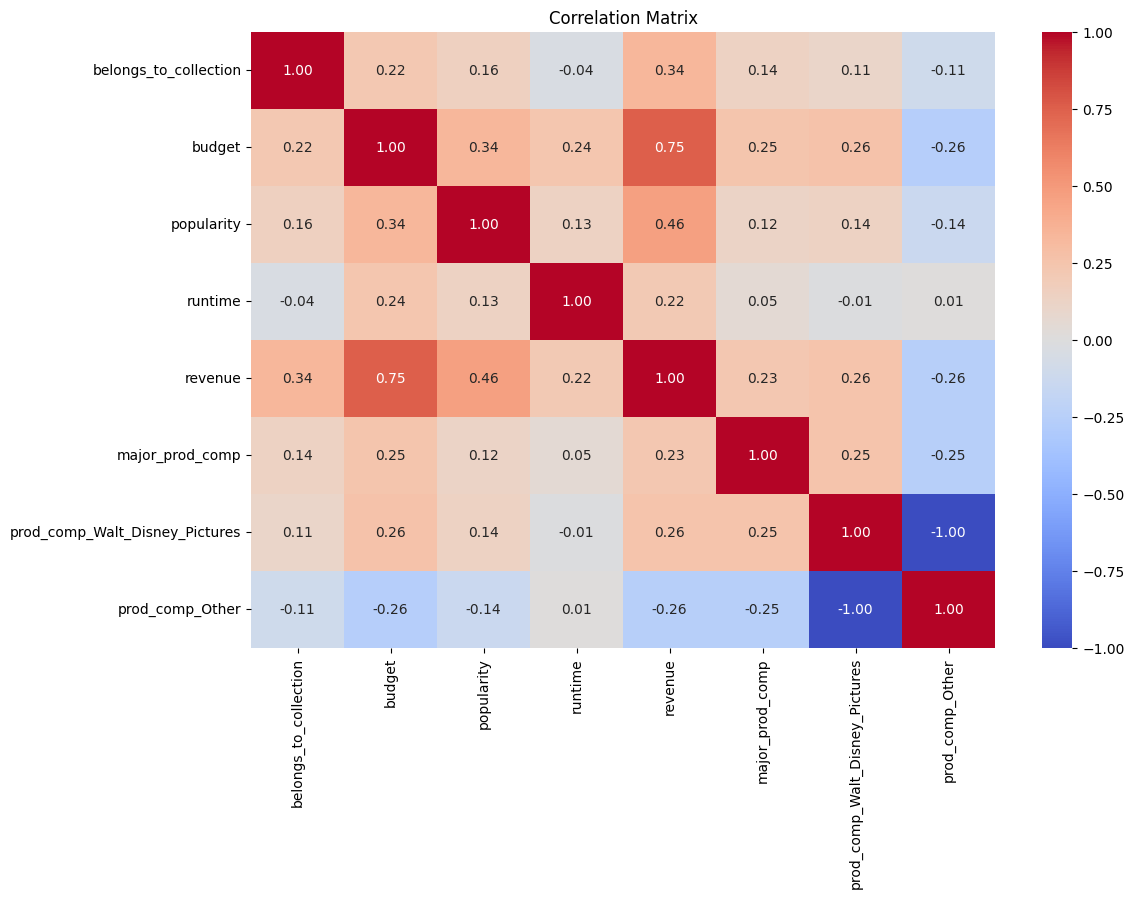

In [1105]:
# Select only numeric columns for correlation matrix
numeric_cols = train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

This looks a lot more manageable for later. We added 3 new categorical features we can later use for univariate and potentially for multivariate regression.

#### Cast and Crew

For the `cast` and `crew` the most straight forward transformation possible, is to count how many members of which gender worked on a movie.

*It would be too time consuming to go deep into detail about the caliber of actors and editors. Although it would be interesting to know whether there is a key actor which guarantees a movies success. But then again, this is very dependent on the year of release and many other factors.*

In [1106]:
train[['cast', 'crew']].head(5)

,cast,crew
0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de..."
1,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de..."
2,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de..."
3,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de..."
4,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de..."


> The code for this transformation came from [Saba Tavoosi](https://www.kaggle.com/code/tavoosi/predicting-box-office-revenue-with-random-forest/report#gender-of-cast-crew).

In [1107]:
# Total cast count and by gender
train['number_of_cast'] = train['cast'].str.count('name')
train['female_cast'] = train['cast'].str.count(r'gender\'\:\s1')
train['male_cast'] = train['cast'].str.count(r'gender\'\:\s2')
train['unspecified_cast'] = train['cast'].str.count(r'gender\'\:\s0')

# Total crew count and by gender
train['number_of_crew'] = train['crew'].str.count('name')
train['female_crew'] = train['crew'].str.count(r'gender\'\:\s1')
train['male_crew'] = train['crew'].str.count(r'gender\'\:\s2')
train['unspecified_crew'] = train['crew'].str.count(r'gender\'\:\s0')

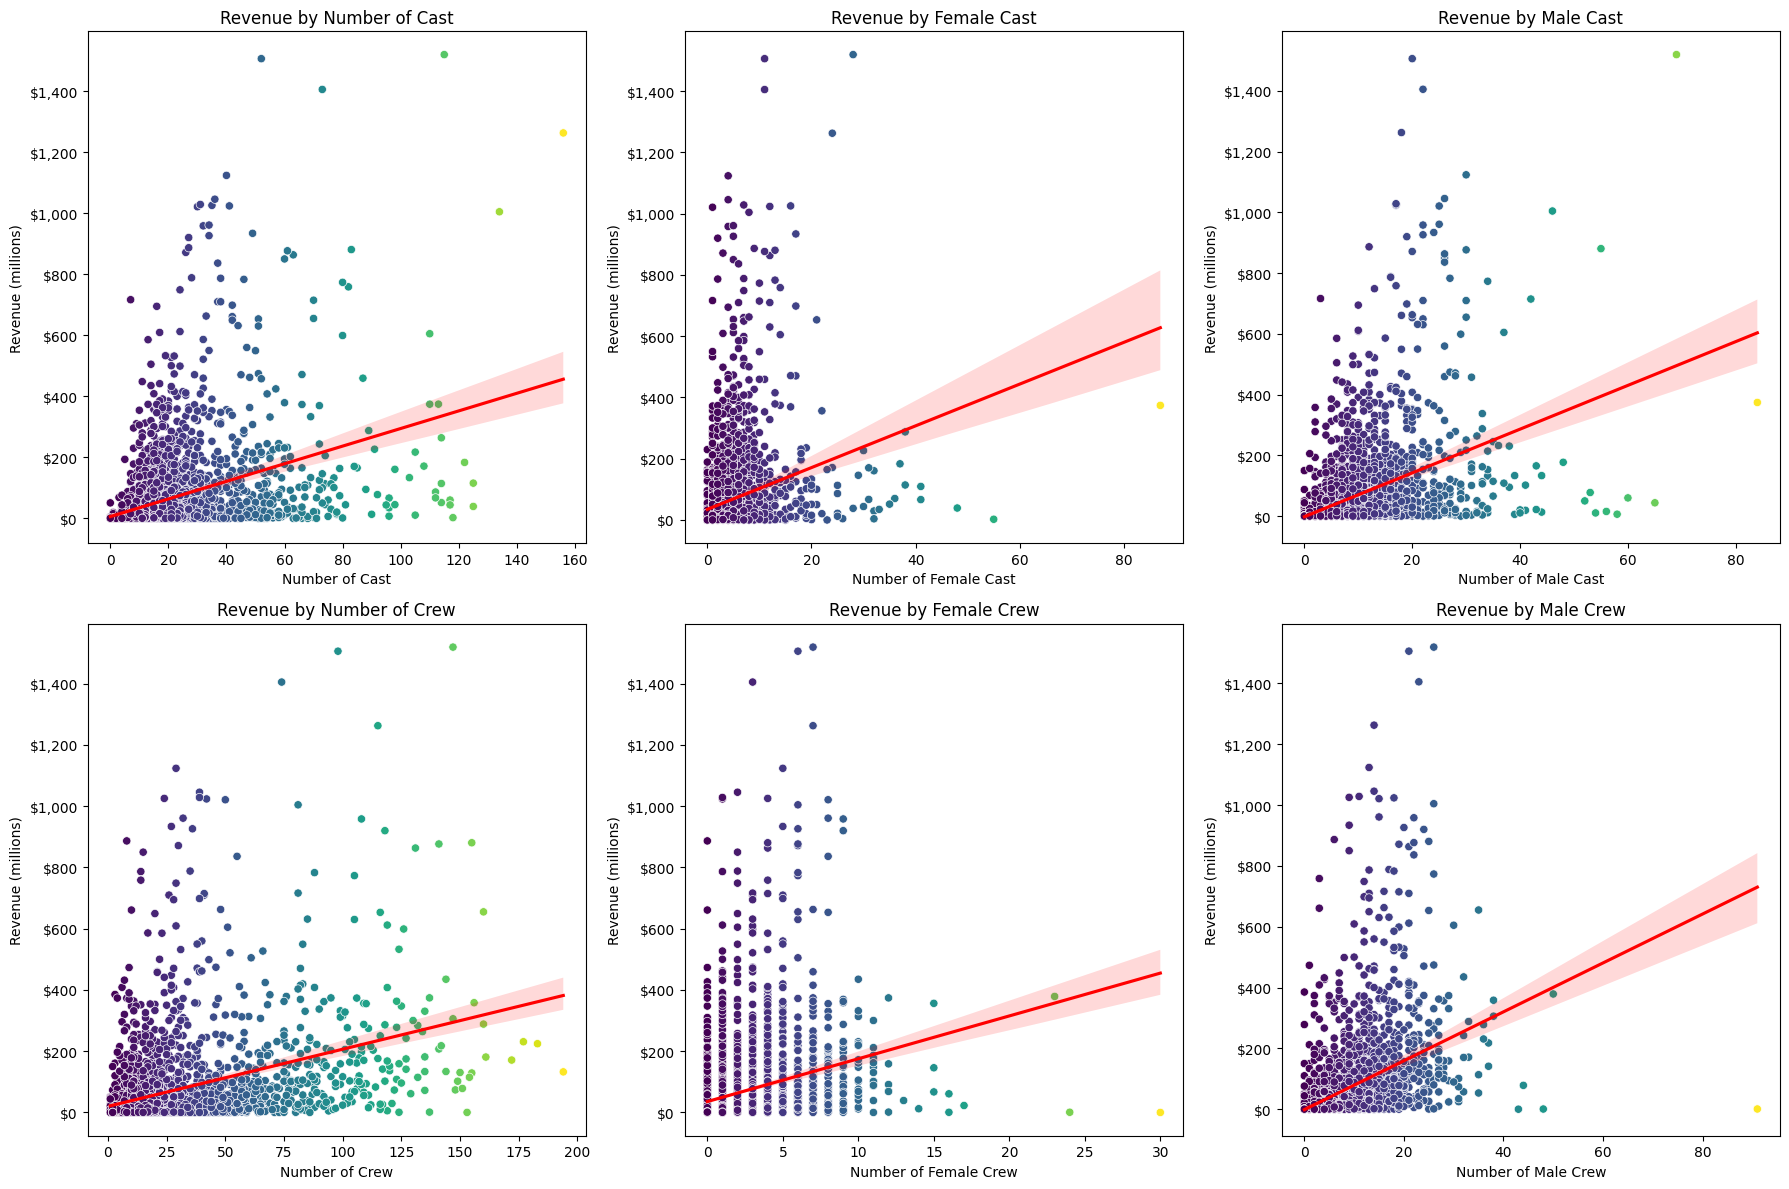

In [1108]:
# Create subplots
plt.figure(figsize=(18, 12))

# Number of cast
plt.subplot(2, 3, 1)
sns.scatterplot(data=train, x='number_of_cast', y='revenue', hue='number_of_cast', palette='viridis')
sns.regplot(data=train, x='number_of_cast', y='revenue', scatter=False, color='red')
plt.title('Revenue by Number of Cast')
plt.xlabel('Number of Cast')
plt.ylabel('Revenue (millions)')
plt.yticks(np.arange(0, 1600000000, 200000000), [f'${x//1000000:,}' for x in np.arange(0, 1600000000, 200000000)])
plt.legend().remove()

# Female cast
plt.subplot(2, 3, 2)
sns.scatterplot(data=train, x='female_cast', y='revenue', hue='female_cast', palette='viridis')
sns.regplot(data=train, x='female_cast', y='revenue', scatter=False, color='red')
plt.title('Revenue by Female Cast')
plt.xlabel('Number of Female Cast')
plt.ylabel('Revenue (millions)')
plt.yticks(np.arange(0, 1600000000, 200000000), [f'${x//1000000:,}' for x in np.arange(0, 1600000000, 200000000)])
plt.legend().remove()

# Male cast
plt.subplot(2, 3, 3)
sns.scatterplot(data=train, x='male_cast', y='revenue', hue='male_cast', palette='viridis')
sns.regplot(data=train, x='male_cast', y='revenue', scatter=False, color='red')
plt.title('Revenue by Male Cast')
plt.xlabel('Number of Male Cast')
plt.ylabel('Revenue (millions)')
plt.yticks(np.arange(0, 1600000000, 200000000), [f'${x//1000000:,}' for x in np.arange(0, 1600000000, 200000000)])
plt.legend().remove()

# Number of crew
plt.subplot(2, 3, 4)
sns.scatterplot(data=train, x='number_of_crew', y='revenue', hue='number_of_crew', palette='viridis')
sns.regplot(data=train, x='number_of_crew', y='revenue', scatter=False, color='red')
plt.title('Revenue by Number of Crew')
plt.xlabel('Number of Crew')
plt.ylabel('Revenue (millions)')
plt.yticks(np.arange(0, 1600000000, 200000000), [f'${x//1000000:,}' for x in np.arange(0, 1600000000, 200000000)])
plt.legend().remove()

# Female crew
plt.subplot(2, 3, 5)
sns.scatterplot(data=train, x='female_crew', y='revenue', hue='female_crew', palette='viridis')
sns.regplot(data=train, x='female_crew', y='revenue', scatter=False, color='red')
plt.title('Revenue by Female Crew')
plt.xlabel('Number of Female Crew')
plt.ylabel('Revenue (millions)')
plt.yticks(np.arange(0, 1600000000, 200000000), [f'${x//1000000:,}' for x in np.arange(0, 1600000000, 200000000)])
plt.legend().remove()

# Male crew
plt.subplot(2, 3, 6)
sns.scatterplot(data=train, x='male_crew', y='revenue', hue='male_crew', palette='viridis')
sns.regplot(data=train, x='male_crew', y='revenue', scatter=False, color='red')
plt.title('Revenue by Male Crew')
plt.xlabel('Number of Male Crew')
plt.ylabel('Revenue (millions)')
plt.yticks(np.arange(0, 1600000000, 200000000), [f'${x//1000000:,}' for x in np.arange(0, 1600000000, 200000000)])
plt.legend().remove()

plt.tight_layout()
plt.show()

Just as thaught in the beginning, there is a trend between the number of `cast`/`crew` and the `revenue` generated.

Let's take a look at the correlations.

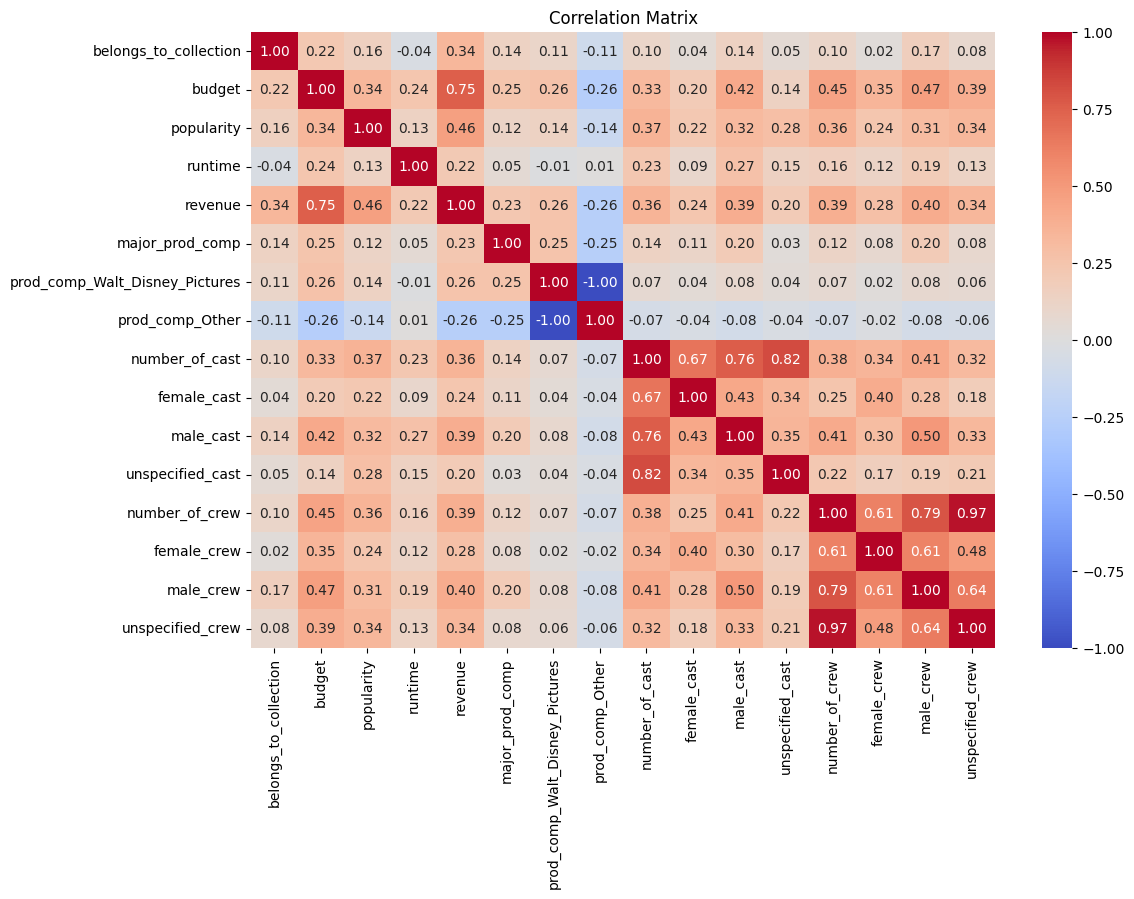

In [1109]:
# Select only numeric columns for correlation matrix
numeric_cols = train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

There are some very respectable correlations between the new features and revenue. I will keep all 6 of the newly added features and compare them later on in the univariate regression.

#### Language

The language spoken in a film can significantly impact its box office revenue due to factors such as audience reach, cultural preferences, and market dynamics.

In [1110]:
train['spoken_languages'].head()

0             [{'iso_639_1': 'en', 'name': 'English'}]
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
Name: spoken_languages, dtype: object

In [1111]:
# Create a new column 'main_language' with the iso_639_1 value of the first index
train['main_language'] = train['spoken_languages'].apply(lambda x: ast.literal_eval(x)[0]['iso_639_1'] if pd.notna(x) and ast.literal_eval(x) else None)

# Correct 'cn' to 'zh'
train['main_language'] = train['main_language'].replace({'cn': 'zh'})

# Count the occurrences of each main language
main_language_counts = train['main_language'].value_counts()

# Print the ordered list
main_language_counts.head(10)

main_language
en    2375
fr      83
es      60
ru      57
de      55
zh      48
ja      42
hi      41
it      27
ar      21
Name: count, dtype: int64

Knowing the domain, it is highly unlikely that a non English movie is going to become a global blockbuster. For this reason I will only classify the movies into `English` and `Other`.

In [1112]:
# Reassign the values in main_language
train['main_language'] = train['main_language'].apply(lambda x: x if x in ['en'] else 'Other')

# Display the updated main_language counts to verify
train['main_language'].value_counts()

# Create binary columns for each language in main_language
for lang in ['en', 'Other']:
    column_name = f'lang_{lang}'
    train[column_name] = train['main_language'].apply(lambda x: 1 if x == lang else 0)

# Display the first few rows to verify
train.head()

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,female_cast,male_cast,unspecified_cast,number_of_crew,female_crew,male_crew,unspecified_crew,main_language,lang_en,lang_Other
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,...,8.0,10.0,6.0,72.0,0.0,13.0,59.0,en,1,0
1,1,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,...,10.0,10.0,0.0,9.0,4.0,4.0,1.0,en,1,0
2,0,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,7.0,13.0,31.0,64.0,4.0,11.0,49.0,en,1,0
3,0,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,...,1.0,2.0,4.0,3.0,0.0,0.0,3.0,en,1,0
4,0,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,...,0.0,4.0,0.0,2.0,0.0,0.0,2.0,Other,0,1


In [1113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   belongs_to_collection           3000 non-null   int64  
 1   budget                          3000 non-null   int64  
 2   genres                          2993 non-null   object 
 3   homepage                        946 non-null    object 
 4   imdb_id                         3000 non-null   object 
 5   original_language               3000 non-null   object 
 6   original_title                  3000 non-null   object 
 7   overview                        2992 non-null   object 
 8   popularity                      3000 non-null   float64
 9   poster_path                     2999 non-null   object 
 10  production_countries            2945 non-null   object 
 11  release_date                    3000 non-null   object 
 12  runtime                         30

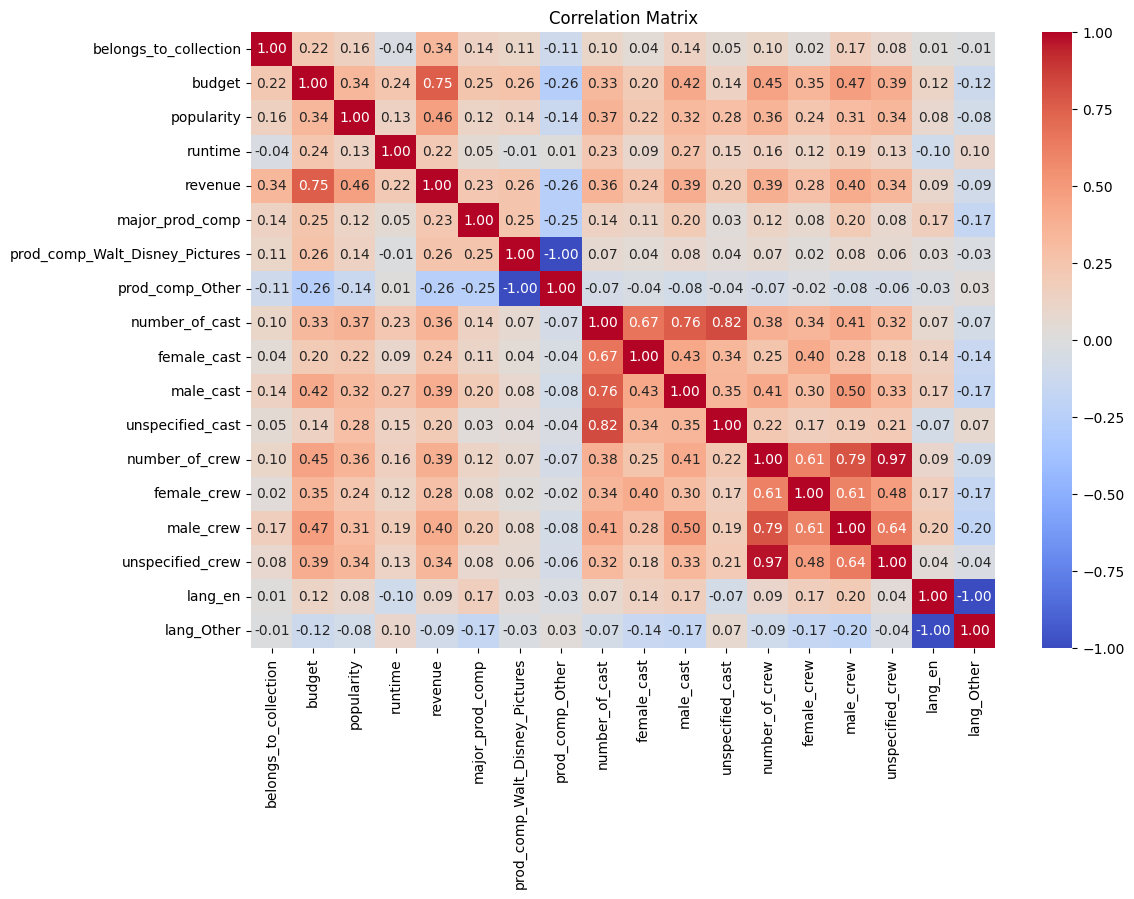

In [1114]:
# Select only numeric columns for correlation matrix
numeric_cols = train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

Surprisingly it seems that the language does not really correlate with the revenue. Let's keep the two new categorical features and see later on if they help training the model.

#### Release Date

The timing of a film's release can significantly influence its box office performance due to factors such as seasonal audience behavior, competition, and marketing strategies.

- Releasing films during peak movie-going periods, like summer or holidays, can lead to higher revenues.
- Scheduling releases to avoid clashing with other major films can enhance box office success.
- Coordinated release dates can create cultural events that boost audience interest, e.g. the "Barbenheimer" phenomenon in July 2023, where "Barbie" and "Oppenheimer" were released simultaneously, exemplifies this effect.]
- Also Movies released either very early or late in the year might be competeting primarily for the Academy Awards and not for high revenues.

In [1115]:
# Convert the 'release_date' column to datetime format with a cutoff year
def parse_date_with_cutoff(date_str, cutoff=20):
    date = pd.to_datetime(date_str, format='%m/%d/%y', errors='coerce')
    if date.year > 2000 + cutoff:
        date = date.replace(year=date.year - 100)
    return date

train['release_date_mod'] = train['release_date'].apply(parse_date_with_cutoff)
train['year_released'] = train['release_date_mod'].dt.year
train['quarter_released'] = train['release_date_mod'].dt.quarter
train['month_released'] = train['release_date_mod'].dt.strftime('%B')
train['week_released'] = train['release_date_mod'].dt.isocalendar().week.astype(int)
train['weekday_released'] = train['release_date_mod'].dt.strftime('%A')
train[['release_date', 'year_released', 'quarter_released', 'month_released', 'week_released', 'weekday_released']].head()

,release_date,year_released,quarter_released,month_released,week_released,weekday_released
0,2/20/15,2015,1,February,8,Friday
1,8/6/04,2004,3,August,32,Friday
2,10/10/14,2014,4,October,41,Friday
3,3/9/12,2012,1,March,10,Friday
4,2/5/09,2009,1,February,6,Thursday


> Inspiration for the plot design came from [Saba Tavoosi](https://www.kaggle.com/code/tavoosi/predicting-box-office-revenue-with-random-forest/report#year-quarter-month-week-and-weekday-released).

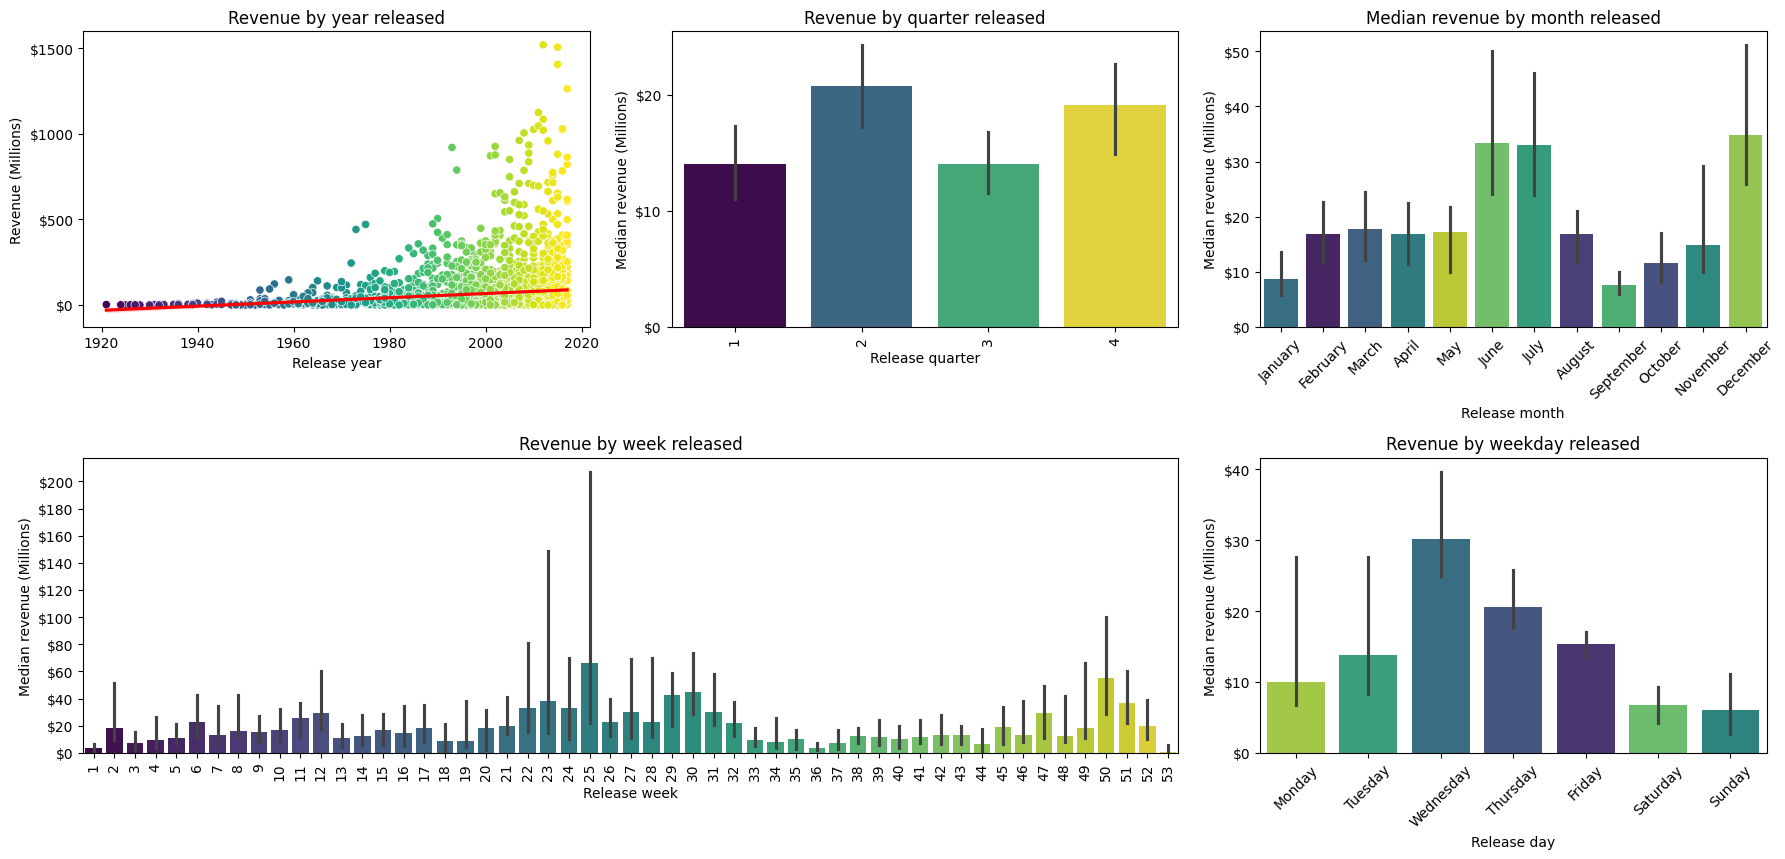

In [1116]:
# Year released plot
plt.figure(figsize=(18, 12))

plt.subplot(3, 3, 1)
sns.scatterplot(data=train.iloc[:3000], x='year_released', y='revenue', hue='year_released', palette='viridis')
sns.regplot(data=train.iloc[:3000], x='year_released', y='revenue', scatter=False, color='red')
plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1000', '$1500'])
plt.title('Revenue by year released')
plt.xlabel('Release year')
plt.ylabel('Revenue (Millions)')
plt.legend().remove()

# Quarter released plot
plt.subplot(3, 3, 2)
sns.barplot(data=train.iloc[:3000], x='quarter_released', y='revenue', estimator=np.median, hue='quarter_released', palette='viridis')
plt.yticks([0, 10000000, 20000000], ['$0', '$10', '$20'])
plt.title('Revenue by quarter released')
plt.xlabel('Release quarter')
plt.ylabel('Median revenue (Millions)')
plt.xticks(rotation=90)
plt.legend().remove()

# Month released plot
plt.subplot(3, 3, 3)
order_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.barplot(data=train.iloc[:3000], x='month_released', y='revenue', estimator=np.median, hue='month_released', palette='viridis', order=order_months)
plt.yticks([0, 10000000, 20000000, 30000000, 40000000, 50000000], ['$0', '$10', '$20', '$30', '$40', '$50'])
plt.title('Median revenue by month released')
plt.xlabel('Release month')
plt.ylabel('Median revenue (Millions)')
plt.xticks(rotation=45)

# Week released plot
plt.subplot(3, 3, (4, 5))
sns.barplot(data=train.iloc[:3000], x='week_released', y='revenue', estimator=np.median, hue='week_released', palette='viridis')
plt.yticks([0, 20000000, 40000000, 60000000, 80000000, 100000000, 120000000, 140000000, 160000000, 180000000, 200000000], ['$0', '$20', '$40', '$60', '$80', '$100', '$120', '$140', '$160', '$180', '$200'])
plt.title('Revenue by week released')
plt.xlabel('Release week')
plt.ylabel('Median revenue (Millions)')
plt.xticks(rotation=90)
plt.legend().remove()

# Weekday released plot
plt.subplot(3, 3, 6)
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(data=train.iloc[:3000], x='weekday_released', y='revenue', estimator=np.median, hue='weekday_released', palette='viridis', order=order_days)
plt.yticks([0, 10000000, 20000000, 30000000, 40000000], ['$0', '$10', '$20', '$30', '$40'])
plt.title('Revenue by weekday released')
plt.xlabel('Release day')
plt.ylabel('Median revenue (Millions)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- **Revenue Over Time:** Revenue appears to have been increasing steadily over the years.  
- **Seasonal Trends:** Movies released in **June, July, and December** tend to achieve higher revenues:  
  - **Summer (June & July):** Popular for blockbuster releases.  
  - **December:** Often associated with Oscar contenders and holiday audiences.  
- **Day of Release:** Movies released on **Wednesdays** show slightly higher revenues, potentially benefiting from extended opening weekend periods.

Let's see how the release correlates with `revenue`.

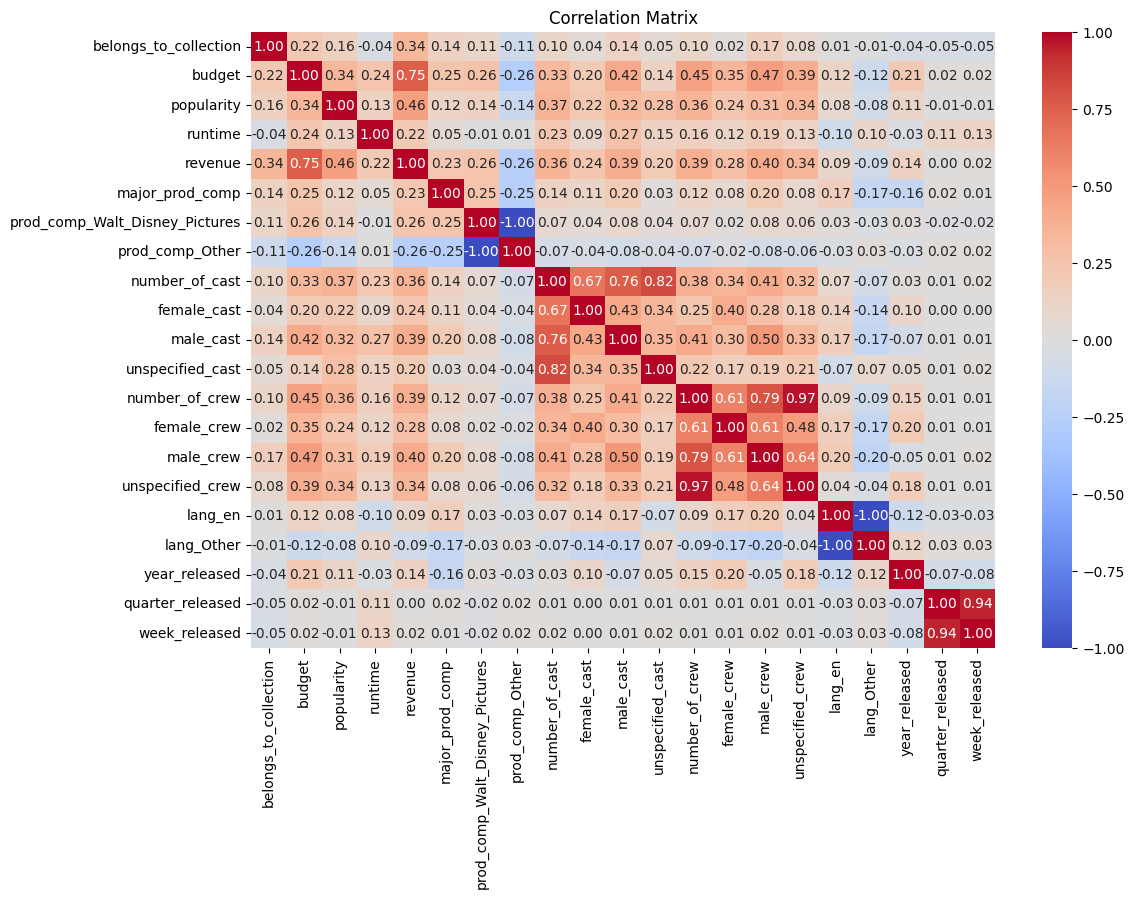

In [1117]:
# Select only numeric columns for correlation matrix
numeric_cols = train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

It seems like the only noticeable correlation is between `year_released` and `revenue`. We can keep the other two features for the moment and measure their significance later on.

#### Genre

Genres in movies have a significant impact on revenue due to audience preferences, production budgets, and marketing strategies. Let's see if we can capture this relation.

I will transform the qualitative feature `genres` using **target encoding** into a quantitative one.

Target encoding replaces each categorical genre with its mean revenue in the dataset, capturing the relationship between genres and the target variable. Here's how it works:

1. Define a threshold for `genre` apperances.
1. Compute the mean `revenue` for each `genre` fulfilling the threshold.
1. Replace genres with mean revenue. Use `global mean` if no genre is provided.

In [1118]:
# Count the number of genres per movie
train['genre_count'] = train['genres'].apply(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)

# Count the number of movies for each genre count
genre_count_distribution = train['genre_count'].value_counts().sort_index()

# Display the distribution
genre_count_distribution

genre_count
0      7
1    593
2    972
3    900
4    393
5    111
6     21
7      3
Name: count, dtype: int64

In [1119]:
# Extract the genres column
train['genres'] = train['genres'].apply(lambda x: [genre['name'] for genre in ast.literal_eval(x)] if pd.notna(x) else [])

# Global mean revenue (used for smoothing)
global_mean = train['revenue'].mean()

# Create an empty dictionary to store the target encoding for each genre
genre_mean = {}

# Define the threshold for the minimum number of movies that must have the genre
threshold = 10

# Calculate the mean revenue for each genre with a count of how many times each genre appears
for _, row in train.iterrows():
    for genre in row['genres']:
        if genre not in genre_mean:
            genre_mean[genre] = {'revenue_sum': 0, 'count': 0}

        genre_mean[genre]['revenue_sum'] += row['revenue']
        genre_mean[genre]['count'] += 1

# Calculate the mean revenue for each genre, but only if it appears more than the threshold
for genre in genre_mean:
    count = genre_mean[genre]['count']
    if count >= threshold:
        genre_mean[genre]['mean_revenue'] = genre_mean[genre]['revenue_sum'] / count
    else:
        genre_mean[genre]['mean_revenue'] = global_mean  # Use global mean if below threshold

# Apply smoothing: use a weighted average of the genre mean and global mean
smoothing_factor = 10  # This is an arbitrary value; adjust based on experimentation
for genre in genre_mean:
    count = genre_mean[genre]['count']
    genre_mean[genre]['smoothed_revenue'] = (genre_mean[genre]['mean_revenue'] * count + global_mean * smoothing_factor) / (count + smoothing_factor)

# Now apply the encoded genre mean revenue values back into the train DataFrame
def encode_genres(genres):
    if not genres:
        return global_mean  # Return global mean if the list is empty
    encoded_values = []
    for genre in genres:
        if genre in genre_mean:
            encoded_values.append(genre_mean[genre]['smoothed_revenue'])
        else:
            encoded_values.append(global_mean)  # For unseen genres, use global mean
    return np.mean(encoded_values)

# Create a new column with target-encoded genre features (mean revenue of genres)
train['encoded_genre_revenue'] = train['genres'].apply(encode_genres)

# Now you can use the 'encoded_genre_revenue' column as a feature for regression, RF, or XGBoost

train[['genres','encoded_genre_revenue']].head()

,genres,encoded_genre_revenue
0,[Comedy],6.093210e+07
1,"[Comedy, Drama, Family, Romance]",7.391190e+07
2,[Drama],4.554442e+07
3,"[Thriller, Drama]",5.693045e+07
4,"[Action, Thriller]",8.938491e+07


Now let's see how the `encoded_genre_revenue` correlates with the target variable.

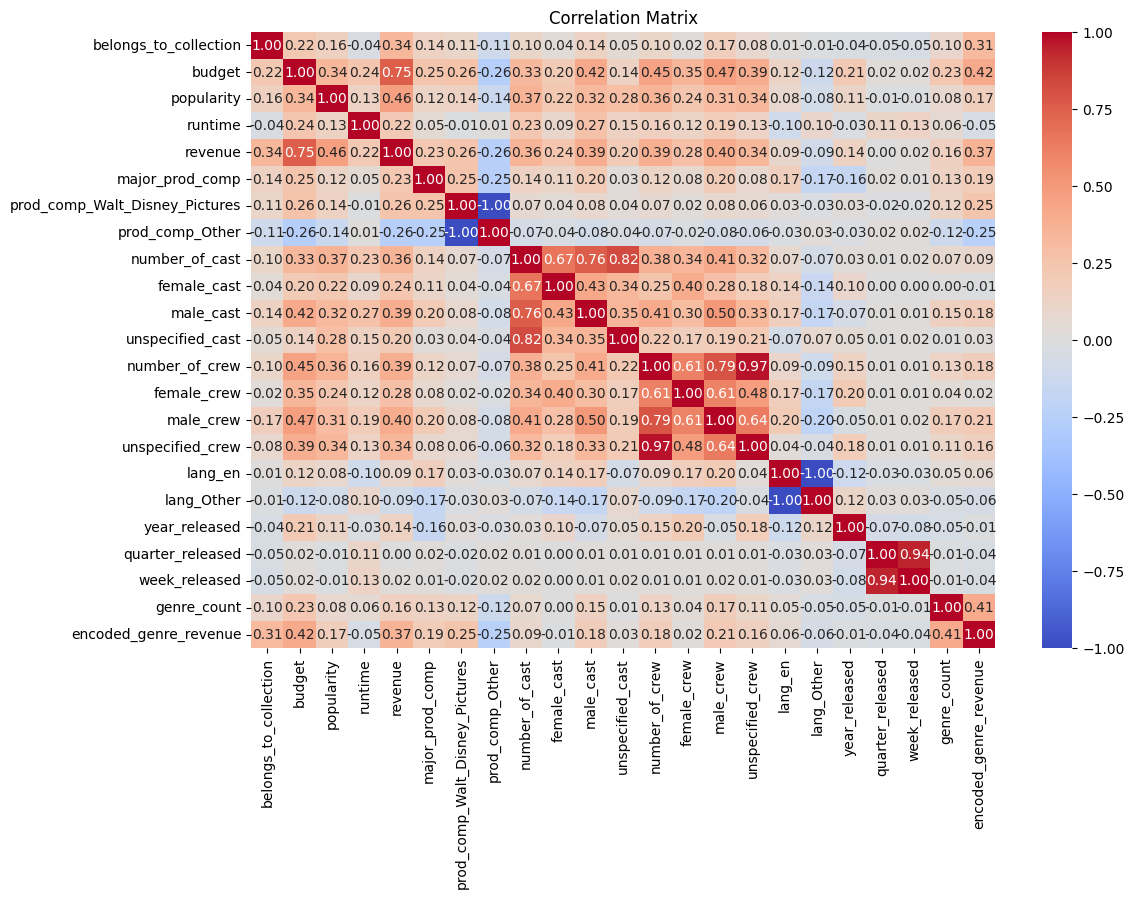

In [1120]:
# Select only numeric columns for correlation matrix
numeric_cols = train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

As a very nice surprise we can see that the `encoded_genre_revenue` indeed correlates noticeably with the revenue. Also `genre_count` could be a helpful predictor later on.

# 3. Univariate Regression

In [1121]:
# Initialize an empty list to store the results
results = []

# Loop through each numeric column
for col in numeric_cols.columns:
    if col != 'revenue':  # Skip the target variable
        X = train[[col]].fillna(train[[col]].median()).astype(float)
        y = train['revenue'].astype(float)
        
        # Add a constant to the model (intercept)
        X = sm.add_constant(X)
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
        
        # Fit the model
        model = sm.OLS(y_train, X_train).fit()
        
        # Get the p-value and coefficient estimate
        p_value = model.pvalues.iloc[1]  # p-value for the feature
        coef = model.params.iloc[1]  # coefficient estimate for the feature
        
        # Calculate the R squared value
        r2 = model.rsquared
        
        # Append the result to the list
        results.append({'Variable': col, 'R_squared': r2, 'P_value': p_value, 'Coefficient': coef})

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Format the values to a uniform human-readable number
results_df['R_squared'] = results_df['R_squared'].apply(lambda x: f'{x:.4f}')
results_df['P_value'] = results_df['P_value'].apply(lambda x: f'{x:.6f}')
results_df['Coefficient'] = results_df['Coefficient'].apply(lambda x: f'{x:,.2f}')

# Sort the DataFrame by R squared in descending order
results_df = results_df.sort_values(by='R_squared', ascending=False)

# Display the results
results_df

,Variable,R_squared,P_value,Coefficient
1,budget,0.5826,0.000000,2.88
2,popularity,0.2157,0.000000,"5,476,470.43"
13,male_crew,0.1508,0.000000,"8,180,963.43"
11,number_of_crew,0.1400,0.000000,"1,916,800.05"
9,male_cast,0.1357,0.000000,"7,001,620.76"
7,number_of_cast,0.1268,0.000000,"3,025,894.37"
21,encoded_genre_revenue,0.1264,0.000000,1.77
0,belongs_to_collection,0.1109,0.000000,"117,860,864.13"
14,unspecified_crew,0.1081,0.000000,"2,191,193.63"
12,female_crew,0.0738,0.000000,"14,232,385.86"


# 4., 5. & 7. Benchmark Multivariate Linear Regression with K-Fold Cross-Validation

In [1122]:
# Define the features and target variable
features = ['budget', 'popularity', 'male_cast', 'belongs_to_collection', 'major_prod_comp', 'runtime', 'encoded_genre_revenue']
X = train[features]
y = train['revenue']

# Fill missing values with the median of each column
X = X.fillna(X.median())

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Initialize lists to store the results
r2_scores = []
adjusted_r2_scores = []
fold_index = 0

# Start the timer
start_time = time.time()

# Perform KFold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    
    # Calculate the adjusted R²
    n = len(y_test)
    k = X_train.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    
    # Append the results to the lists
    r2_scores.append(r2)
    adjusted_r2_scores.append(adjusted_r2)

    # Print R² and adjusted R² for each fold
    print(f"Fold: {fold_index}")
    print(f"R²: \t\t{r2}")
    print(f"Adj. R²: \t{adjusted_r2}")
    print("------------------------------------------")
    fold_index += 1

# End the timer
end_time = time.time()

# Calculate the average R² and adjusted R² scores
lr_average_r2 = sum(r2_scores) / len(r2_scores)
lr_average_adjusted_r2 = sum(adjusted_r2_scores) / len(adjusted_r2_scores)
lr_compute_time = end_time - start_time

print("------------------------------------------")
print(f"Avg. R² Score: \t\t{lr_average_r2}")
print(f"Avg. adj. R² Score: \t{lr_average_adjusted_r2}")
print(f"Time taken: \t\t{lr_compute_time:.2f} seconds")

Fold: 0
R²: 		0.6380817684397415
Adj. R²: 	0.633802329890887
------------------------------------------
Fold: 1
R²: 		0.5858004178948588
Adj. R²: 	0.580902787701048
------------------------------------------
Fold: 2
R²: 		0.6526595356820065
Adj. R²: 	0.6485524693809492
------------------------------------------
Fold: 3
R²: 		0.6208917762622206
Adj. R²: 	0.6164090776707265
------------------------------------------
Fold: 4
R²: 		0.6855408872459468
Adj. R²: 	0.6818226207100035
------------------------------------------
------------------------------------------
Avg. R² Score: 		0.6365948771049548
Avg. adj. R² Score: 	0.6322978570707228
Time taken: 		0.11 seconds


# 6. & 7. Machine Learning Algorithms with K-Fold Cross-Validation

## Random Forest

In [1123]:
X = train.select_dtypes(include=[np.number]).drop(columns=['revenue']).copy()

# Fill missing values with the median of each column
X = X.fillna(X.median())

y = train['revenue']

# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the results
r2_scores = []
adjusted_r2_scores = []

# Start the timer
start_time = time.time()

# Perform KFold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize the Random Forest model
    rf_model = RandomForestRegressor(max_features=12, random_state=42)
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)
    
    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    
    # Calculate the adjusted R²
    n = len(y_test)
    k = X_train.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    
    # Append the results to the lists
    r2_scores.append(r2)
    adjusted_r2_scores.append(adjusted_r2)
    
    # Print R² and adjusted R² for each fold
    print(f"Fold: {len(r2_scores)}")
    print(f"R²: \t\t{r2}")
    print(f"Adj. R²: \t{adjusted_r2}")
    print("------------------------------------------")

# End the timer
end_time = time.time()

# Calculate the average R² and adjusted R² scores
rf_average_r2 = sum(r2_scores) / len(r2_scores)
rf_average_adjusted_r2 = sum(adjusted_r2_scores) / len(adjusted_r2_scores)
rf_compute_time = end_time - start_time

print("------------------------------------------")
print(f"Avg. R² Score: \t\t{rf_average_r2}")
print(f"Avg. adj. R² Score: \t{rf_average_adjusted_r2}")
print(f"Time taken: \t\t{rf_compute_time:.2f} seconds")

Fold: 1
R²: 		0.6911993402589502
Adj. R²: 	0.6794253116379744
------------------------------------------
Fold: 2
R²: 		0.658489135434495
Adj. R²: 	0.6454679239605936
------------------------------------------
Fold: 3
R²: 		0.6922527674275353
Adj. R²: 	0.6805189041405435
------------------------------------------
Fold: 4
R²: 		0.7124008862642628
Adj. R²: 	0.7014352354805778
------------------------------------------
Fold: 5
R²: 		0.7285739914564653
Adj. R²: 	0.7182249928638176
------------------------------------------
------------------------------------------
Avg. R² Score: 		0.6965832241683417
Avg. adj. R² Score: 	0.6850144736167014
Time taken: 		11.23 seconds


In [1124]:
# Get feature importances
rf_importances = rf_model.feature_importances_

# Create a DataFrame for the feature importances
rf_feature_importance_df = pd.DataFrame({
    'Variables': X.columns,
    'Importance': rf_importances
})

# Sort the DataFrame by importance
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

## Gradient Boosting

In [1125]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the results
r2_scores = []
adjusted_r2_scores = []

# Start the timer
start_time = time.time()

# Perform KFold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize the Gradient Boosting model
    gb_model = GradientBoostingRegressor(max_features=12, random_state=42)
    
    # Train the model
    gb_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = gb_model.predict(X_test)
    
    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    
    # Calculate the adjusted R²
    n = len(y_test)
    k = X_train.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    
    # Append the results to the lists
    r2_scores.append(r2)
    adjusted_r2_scores.append(adjusted_r2)
    
    # Print R² and adjusted R² for each fold
    print(f"Fold: {len(r2_scores)}")
    print(f"R²: \t\t{r2}")
    print(f"Adj. R²: \t{adjusted_r2}")
    print("------------------------------------------")

# End the timer
end_time = time.time()

# Calculate the average R² and adjusted R² scores
gb_average_r2 = sum(r2_scores) / len(r2_scores)
gb_average_adjusted_r2 = sum(adjusted_r2_scores) / len(adjusted_r2_scores)
gb_compute_time = end_time - start_time

print("------------------------------------------")
print(f"Avg. R² Score: \t\t{gb_average_r2}")
print(f"Avg. adj. R² Score: \t{gb_average_adjusted_r2}")
print(f"Time taken: \t\t{gb_compute_time:.2f} seconds")

Fold: 1
R²: 		0.6637288377890302
Adj. R²: 	0.6509074069941578
------------------------------------------
Fold: 2
R²: 		0.6692189069533244
Adj. R²: 	0.6566068028856868
------------------------------------------
Fold: 3
R²: 		0.7002207796830716
Adj. R²: 	0.6887907227559097
------------------------------------------
Fold: 4
R²: 		0.6968536179647253
Adj. R²: 	0.6852951770552348
------------------------------------------
Fold: 5
R²: 		0.6796674467265164
Adj. R²: 	0.6674537271909589
------------------------------------------
------------------------------------------
Avg. R² Score: 		0.6819379178233336
Avg. adj. R² Score: 	0.6698107673763897
Time taken: 		2.37 seconds


In [1126]:
# Get feature importances from the gradient boosting model
gb_importances = gb_model.feature_importances_

# Create a DataFrame for the feature importances
gb_feature_importance_df = pd.DataFrame({
    'Variables': X.columns,
    'Importance': gb_importances
})

# Sort the DataFrame by importance
gb_feature_importance_df = gb_feature_importance_df.sort_values(by='Importance', ascending=False)

# 8. Performance Evaluation

In [1127]:
print(f"Model \t\t\t Avg. R² \t\t Avg. adj. R² Score \t Computation Time \t Number of Features")
print("-------------------------------------------------------------------------------------------------------------------")
print(f"Random Forest \t\t {rf_average_r2} \t {rf_average_adjusted_r2} \t {rf_compute_time:.2f} seconds \t\t {rf_model.max_features}")
print(f"Gradient Boosting \t {gb_average_r2} \t {gb_average_adjusted_r2} \t {gb_compute_time:.2f} seconds \t\t {gb_model.max_features}")
print(f"Linear Regression \t {lr_average_r2} \t {lr_average_adjusted_r2} \t {lr_compute_time:.2f} seconds \t\t {features.__len__()}")

Model 			 Avg. R² 		 Avg. adj. R² Score 	 Computation Time 	 Number of Features
-------------------------------------------------------------------------------------------------------------------
Random Forest 		 0.6965832241683417 	 0.6850144736167014 	 11.23 seconds 		 12
Gradient Boosting 	 0.6819379178233336 	 0.6698107673763897 	 2.37 seconds 		 12
Linear Regression 	 0.6365948771049548 	 0.6322978570707228 	 0.11 seconds 		 7


# 9. Key Features

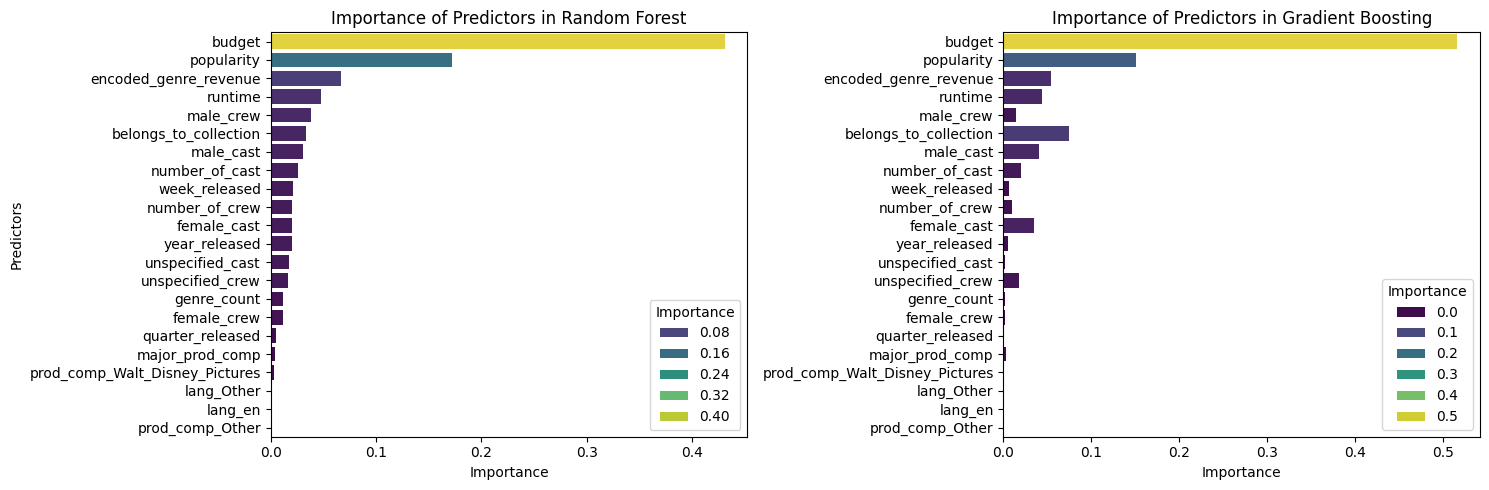

In [1137]:
plt.figure(figsize=(15, 5))

# Plot the feature importances Random Forest
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Variables', data=rf_feature_importance_df, hue='Importance', palette='viridis')
plt.title('Importance of Predictors in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Predictors')

# Plot the feature importances Gradient Boosting with the same order as Random Forest
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Variables', data=gb_feature_importance_df, hue='Importance', palette='viridis', order=rf_feature_importance_df['Variables'])
plt.title('Importance of Predictors in Gradient Boosting')
plt.xlabel('Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()

# 10. Synthetic Interpretation of Results